# Probabilistic Programming with Haskell

Siddhart Bath, Simeon Carstens, Matthias Meschede

_first published on www.tweag.io/blog_

#### imports

In [1]:
:e OverloadedStrings
:e ExistentialQuantification
:e FlexibleContexts

import System.Random.MWC (createSystemRandom)
import qualified Graphics.Vega.VegaLite as VL
import IHaskell.Display.Hvega (vlShow)
import Data.Aeson (ToJSON(toJSON), Value)
import Data.Aeson (encode)
import qualified Data.ByteString.Lazy.Char8 as BL
import Data.Text (Text, pack)
import qualified Data.Histogram as DH
import qualified Data.Histogram.Fill as DF
import qualified Data.Histogram.Bin.Bin2D as Bin2D
import Data.Vector.Unboxed.Base (Unbox)
import qualified Data.Vector.Unboxed as Vec

import Control.Monad (liftM2, replicateM, forM, forM_)
import Control.Monad.IO.Class (liftIO)
import Data.List (sort)
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Traced
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Inference.SMC as SMC
import Control.Monad.Bayes.Inference.RMSMC as RMSMC
import Control.Monad.Bayes.Sequential
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Traced.Static (Traced)
import Control.Monad.Bayes.Inference.SMC
import Numeric.LinearAlgebra (Matrix, Vector, toList, vector, matrix, dot, (#>), (!), cmap, scalar, size)

import Numeric.Log
import Control.Monad.Bayes.Class

import Data.List (partition)

#### Plotting

In [2]:
histo2D :: (Foldable f, Unbox val, Num val) =>
    (Double, Int, Double)
    -> (Double, Int, Double)
    -> f (Double, Double)
    -> DH.Histogram (Bin2D.Bin2D DH.BinD DH.BinD) val
histo2D (xmin, xn, xmax) (ymin, yn, ymax) = DF.fillBuilder buildr
  where
    binX = DH.binD xmin xn xmax
    binY = DH.binD ymin yn ymax
    bins = Bin2D.Bin2D binX binY
    buildr = DF.mkSimple bins
    
histo :: (Foldable v, Unbox a, Num a) =>
         (Double, Int, Double)
      -> v Double
      -> DH.Histogram DF.BinD a
histo (xmin, n, xmax) = DF.fillBuilder buildr
  where
    bins = DH.binD xmin n xmax
    buildr = DF.mkSimple bins

In [3]:
barPlot :: Text -> VL.VLSpec
barPlot xName = 
    let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Nominal]
            . VL.position VL.Y [VL.PName "binnedData", VL.PAggregate VL.Count, VL.PmType VL.Quantitative, VL.PAxis [VL.AxTitle "count"]]
    in VL.asSpec [VL.mark VL.Bar [VL.MOpacity 1.0, VL.MColor "#a3c6de"], encoding []]

linePlot :: Text -> Text -> VL.VLSpec
linePlot xName yName = 
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative]
  in VL.asSpec [VL.mark VL.Line [VL.MColor "blue"], encoding []]

scatterBlue xName yName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
  in VL.asSpec [VL.mark VL.Circle [VL.MColor "blue"], encoding []]
  
scatterGreen xName yName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
  in VL.asSpec [VL.mark VL.Circle [VL.MColor "green"], encoding []]
  
scatterPlotWithColor :: Text -> Text -> Text -> (Double, Double) -> (Double, Double) -> VL.VLSpec
scatterPlotWithColor xName yName zName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
            . VL.color [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
  in VL.asSpec [VL.mark VL.Circle [], encoding []]

density2DPlot :: Text -> Text -> (Double, Double) -> (Double, Double) -> VL.VLSpec
density2DPlot xName yName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PBin [VL.Nice False, VL.Steps [0.05, 0.5, 5.0], VL.Extent xmin xmax], VL.PmType VL.Quantitative]
            . VL.position VL.Y [VL.PName yName, VL.PBin [VL.Nice False, VL.Steps [0.05, 0.5, 5.0], VL.Extent ymin ymax], VL.PmType VL.Quantitative]
            . VL.color [ VL.MAggregate VL.Count, VL.MName "col", VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
  in VL.asSpec [VL.mark VL.Rect [], encoding []]

imagePlot :: Text -> Text -> Text -> VL.VLSpec
imagePlot xName yName zName =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Nominal, VL.PAxis [VL.AxGridOpacity 0.1]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Nominal, VL.PSort [VL.Descending], VL.PAxis [VL.AxGridOpacity 0.1]]
            . VL.fill [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
            . VL.stroke [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]],
                          VL.MLegend [VL.LType VL.GradientLegend]]
  in VL.asSpec [VL.mark VL.Rect [], encoding []]
  
imageFacetPlot :: Text -> Text -> Text -> VL.VLSpec
imageFacetPlot xName yName zName =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Ordinal, VL.PAxis [VL.AxGrid False]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Ordinal, VL.PSort [VL.Descending], VL.PAxis [VL.AxGrid False]]
            . VL.fill [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]], VL.MLegend [VL.LOrient VL.LOBottom]]
            . VL.stroke [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]],
                          VL.MLegend [VL.LOrient VL.LOBottom, VL.LDirection VL.Horizontal, VL.LType VL.GradientLegend]]
  in VL.asSpec [VL.mark VL.Rect [], encoding [], VL.width 200,  VL.height 100]

data SpecGrid = H [[VL.VLSpec]] | V [[VL.VLSpec]] | L [VL.VLSpec] | S VL.VLSpec | F (Text, Int, VL.VLSpec)

data InputData = Cols [(Text, VL.DataValues)]
               | File FilePath

plot :: (Double, Double) -> SpecGrid -> InputData -> VL.VegaLite
plot (figw,figh) specGrid dataPoints =
    let description = VL.description "Plot"
        dat' = case dataPoints of
            Cols cols -> foldl (.) (VL.dataFromColumns []) (map (uncurry VL.dataColumn) cols) []
            File fp -> VL.dataFromSource (pack fp) []
        configure = VL.configure
            . VL.configuration (VL.Axis
                                        [ VL.Domain False,
                                          VL.LabelColor "#7F7F7F",
                                          VL.LabelPadding 4,
                                          VL.TickColor "#7F7F7F",
                                          VL.TickSize 5.67,
                                          VL.Grid True,
                                          VL.GridColor "#FFFFFF"
                                          ])
        spec = case specGrid of
            S s -> VL.layer [s]
            L ls -> VL.layer ls
            H lss -> VL.hConcat (map (VL.asSpec . (:[]) . VL.layer) lss)
            V lss -> VL.vConcat (map (VL.asSpec . (:[]) . VL.layer) lss)
            F (_, _, s) -> VL.specification s
        facet = case specGrid of
            F (field, nColumns, _) -> [VL.columns $ fromIntegral nColumns, VL.facetFlow [VL.FName field, VL.FmType VL.Nominal]]
            _   -> [VL.width figw,  VL.height figh]
    in VL.toVegaLite $ [VL.background "#f9f9f9", configure [], description, dat', spec] ++ facet

## Part 3: A Simple Neural Network

This post is the third instalment of Tweag's _**Probabilistic Programming with monad‑bayes Series**_.
You can find the previous parts here:

* [Part 1: Introduction](https://www.tweag.io/posts/2019-09-20-monad-bayes-1.html)
* [Part 2: Linear Regression here](https://www.tweag.io/posts/2019-11-08-monad-bayes-2.html)

Want to make this post interactive?
Try our [notebook version](https://github.com/tweag/blog-resources/tree/master/monad-bayes-series).
It includes a Nix shell, the required imports, and some helper routines for plotting. Let's start modeling!

## Introduction

Where we left off, we had learned to see linear regression not as drawing a line through a data set —
we have seen it rather as figuring out how likely it is that a line from a whole _distribution_ of lines generates the observed data set.

The entire point of this is that once you know how to do this for lines, you can start fitting any model in the same fashion.
In this blog post, we shall use a neural network.

This will demonstrate one of the great strengths of `monad-bayes`:
it doesn't have a preconceived idea of what a model should look like.
It can define distributions of anything that you can define in Haskell.

We will need to do some linear algebra computations, which we will do with the [`hmatrix`](https://hackage.haskell.org/package/hmatrix) package.

## Model Setup

In our last blog post, we have illustrated that a likelihood model defines a parametrized family of data distributions.
In linear regression these data distributions are centered around lines parametrized by their _slope, and intercept_, with variations around them parametrized by _sigma_.
In this post, we again setup such a likelihood model, but now the distributions aren't centered on lines.
Instead, they are centered on the output of a neural network that is parametrized by a _weight_ vector and a _bias_ vector, with a _sigma_ parameter defining variations around the network output.
Therefore, our (very simple) neural network will be represented by:

In [4]:
data NN
  = NN
      { biass :: Vector Double,
        weights :: Vector Double,
        sigma :: Double
      }
  deriving (Eq, Show)

In a Bayesian approach, a neural network computes, given some input, a probability distribution for possible outputs.
For instance, the input may be a picture, and the output a distribution of picture labels of what is in the picture (is it a camel, a car, or a house?).
For this blog post, we will consider the x-coordinate as the input, and a distribution of y-coordinates (y-distribution) as the output.
This will be represented by the following:

In [5]:
data Data
  = Data
      { xValue :: Double,
        yValue :: Double
      }
  deriving (Eq, Show)

Let's start by defining the x-dependent mean of the y-distribution (_y-mean_):

In [6]:
forwardNN :: NN -> Double -> Double
forwardNN (NN bs ws _) x =
    ws `dot` cmap activation (scalar x - bs)
  where activation x = if x < 0 then 0 else 1

For a given set of neural network parameters `NN`, `forwardNN` returns a function from `Double` to `Double`, from x to the y-mean of the data distribution.
A full y-distribution can easily be obtained by adding normally-distributed variations around the y-mean:

In [7]:
errorModel :: Double -> Double -> Double -> Log Double
errorModel mean std = normalPdf mean std

Line 2: Eta reduce
Found:
errorModel mean std = normalPdf mean std
Why not:
errorModel = normalPdf

The first two arguments of `errorModel` are the y-mean and y-sigma of the normal distribution.
When this normal distribution is evaluated at a position y, which is the third parameter, the `errorModel` function returns the log-probability.
What we've just said in two lengthy sentences can be combined into a single `likelihood` model like this:

In [8]:
likelihood :: NN -> Data -> Log Double
likelihood nn (Data xObs yObs) =
    errorModel yMean ySigma yObs
  where
    ySigma = sigma nn
    yMean = forwardNN nn xObs

This function embodies our likelihood model:
for given parameter values `NN`, it returns a data distribution, a function that assigns a log-probability to each data point.
We can, for example, pick a specific neural network:

In [9]:
nn = NN
  { biass=vector [1, 5, 8]
  , weights=vector [2, -5, 1]
  , sigma=2.0
  }

and then plot the corresponding distribution:

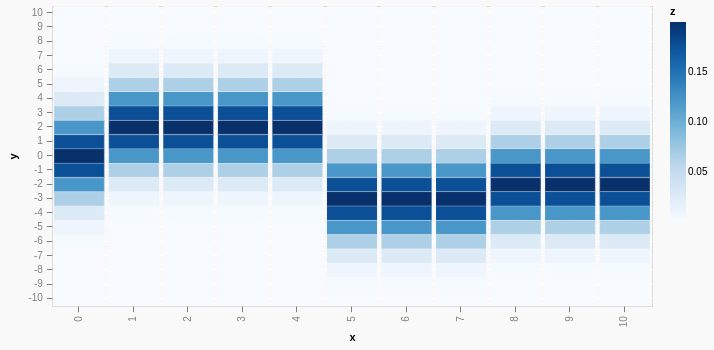

In [10]:
points1 =
  [ (x, y, exp . ln $ likelihood nn (Data x y))
  | x <- [0 .. 10]
  , y <- [-10 .. 10]
  ]

vlShow $
  plot
    (600, 300)
    (L [imagePlot "x" "y" "z"])
    ( Cols
        [ ("x", VL.Numbers ((\(x, _, _) -> x) <$> points1)),
          ("y", VL.Numbers ((\(_, x, _) -> x) <$> points1)),
          ("z", VL.Numbers ((\(_, _, x) -> x) <$> points1))
        ]
    )

We can see that our neural networks computes distributions centered around a step function.
The positions of the steps are determined by the biases, while their height is determined by the weights.
There is one step per node in our neural network (3 in this example).

## Prior, Posterior and Predictive Distribution

Now let's try and train this step-function network.
But instead of traditional training, we will find out a whole distribution of neural networks, weighted by how likely they are to generate the observed data.
Monad-bayes knows nothing of our `NN` data type, so it may sound like we have to do something special to teach `NN` to monad-bayes.
But none of that is necessary:
monad-bayes simply lets us specify distributions of _any_ data type.
In the `NN` case, this is represented by `m NN` for some `MonadInfer m`.

In the Bayesian context, training consists in computing a posterior distribution after observing the data in the training set.
In standard monad-bayes fashion this is achieved by scoring with the likelihood that a model generates all points in the training set.
Haskell's combinators make this very succinct.

In [11]:
postNN :: MonadInfer m => m NN -> [Data] ->  m NN
postNN pr obs = do
  nn <- pr
  forM_ obs (score . likelihood nn)
  return nn

We also need an uninformative prior to initiate the computation.
Let's choose a uniform distribution on the permissible parameters.

In [12]:
uniformVec :: MonadSample m => (Double, Double) -> Int -> m (Vector Double)
uniformVec (wmin, wmax) nelements =
  vector <$> replicateM nelements (uniform wmin wmax)

priorNN :: MonadSample m => Int -> m NN
priorNN nnodes = do
  bias <- uniformVec (0, 10) nnodes
  weight <- uniformVec (-10, 10) nnodes
  sigma <- uniform 0.5 1.5
  return $ NN bias weight sigma

Notice how we create a distribution of vectors in `uniformVec`, as `m (Vector Double)`.
As was the case for neural networks, monad-bayes doesn't know anything about vectors.

Finally, we can use the posterior distribution to predict more data.
To predict a data point, we literally draw uniformly from permissible points, then score them according to the neural network distribution.
Monad-bayes ensures that this can be done efficiently.

In [13]:
predDist :: MonadInfer m => m NN -> m (NN, Data)
predDist pr = do
  nn <- pr
  x <- uniform 0 10
  y <- uniform (-5) 10
  score $ likelihood nn (Data x y)
  return (nn, Data x y)

We return the neural network alongside the actual data point, this is mere convenience.

## Some Examples

With this setup, we can infer a predictive data distribution from observations.
Let's see how our network handles a line with slope `0.5` and intercept `-2`:

In [14]:
nsamples = 200
noise <- sampleIOfixed $ replicateM nsamples $ normal 0.0 0.5
observations =
  [ Data x (0.5 * x - 2 + n)
  | (x,n) <- zip [0, (10 / nsamples) ..] noise
  ]


We can sample from the predictive data distribution with this snippet:

In [15]:
nnodes = 3
mkSampler = prior . mh 60000
predicted <-
  sampleIOfixed $ mkSampler $ predDist $
  postNN (priorNN nnodes) observations

And we get this distribution:

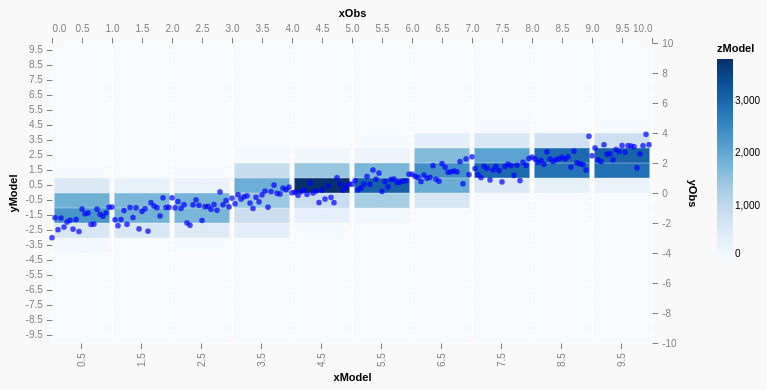

In [16]:
hist =
  histo2D (0, 10, 10) (-10, 20, 10)
    ((\(_, d)-> (xValue d, yValue d)) <$> predicted)
cents = Vec.toList $ DH.binsCenters $ DH.bins hist
val = Vec.toList $ DH.histData hist

vlShow $
  plot
    (600, 300)
    (L [imagePlot "xModel" "yModel" "zModel",
        scatterBlue "xObs" "yObs" (0, 10) (-10, 10)])
    ( Cols
        [ ("xModel", VL.Numbers (fst <$> cents)),
          ("yModel", VL.Numbers (snd <$> cents)),
          ("zModel", VL.Numbers val),
          ("xObs", VL.Numbers (xValue <$> observations)),
          ("yObs", VL.Numbers (yValue <$> observations))
        ]
    )

The predictive data distribution, shown with a blue histogram, neatly follows the observed blue scatter points.
We have thus successfully "fitted" a line with a neural network using Bayesian inference!
Of course, the predictive distribution is less precise than if it were, in fact, a line, since our networks' distributions are always in the form of a step function.

Lines are not very interesting, so let's observe a sine wave next:

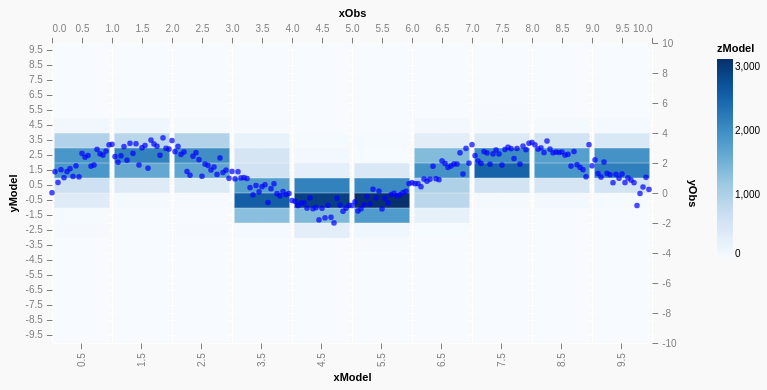

In [17]:
nsamples = 200
noise <- sampleIOfixed $ replicateM nsamples $ normal 0.0 0.5
observations = take nsamples
  [ Data x (2 * sin x + 1 + n)
  | (x, n) <- zip [0, (10 / nsamples) ..] noise
  ]

nnodes = 3
mkSampler = prior . mh 60000
predicted <-
  sampleIOfixed $ mkSampler $ predDist $
  postNN (priorNN nnodes) observations

hist =
  histo2D (0, 10, 10) (-10, 20, 10)
    ((\(nn, d) -> (xValue d, yValue d)) <$> predicted)
cents = Vec.toList $ DH.binsCenters $ DH.bins hist
val = Vec.toList $ DH.histData hist

vlShow $
  plot
    (600, 300)
    (L [imagePlot "xModel" "yModel" "zModel", scatterBlue "xObs" "yObs" (0, 10) (-10, 10)])
    ( Cols
        [ ("xModel", VL.Numbers (fst <$> cents)),
          ("yModel", VL.Numbers (snd <$> cents)),
          ("zModel", VL.Numbers val),
          ("xObs", VL.Numbers (xValue <$> observations)),
          ("yObs", VL.Numbers (yValue <$> observations))
        ]
    )

Pretty neat! We can still see the three steps.
Still, we get a reasonable approximation of our sine wave.

What if, instead of visualising the data distribution, we observed the distribution of neural networks themselves?
That is, the distributions of weights and biases.

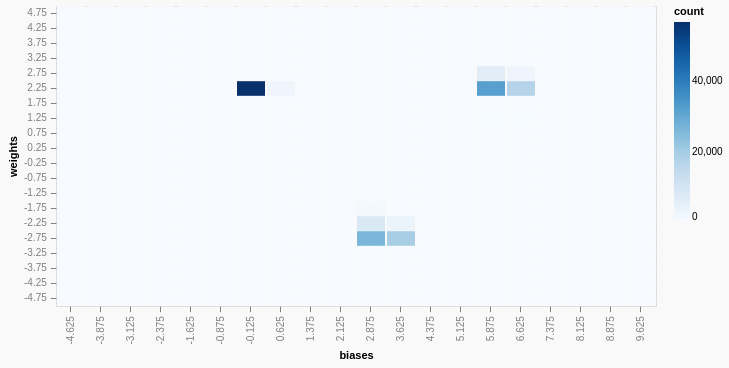

In [18]:
ws = mconcat $ toList . weights . fst <$> predicted
bs = mconcat $ toList . biass . fst <$> predicted

hist = histo2D (-5, 20, 10) (-5, 20, 5) (zip bs ws)
cents = Vec.toList $ DH.binsCenters $ DH.bins hist
val = Vec.toList $ DH.histData hist

vlShow $
  plot
    (600, 300)
    (L [imagePlot "biases" "weights" "count"])
    ( Cols
        [ ("biases", VL.Numbers (fst <$> cents)),
          ("weights", VL.Numbers (snd <$> cents)),
          ("count", VL.Numbers val)]
    )

The x-axis shows the step positions (`biasVec`) and the y-axis shows the step amplitudes (`weightVec`).
We have trained a three-node (_i.e._ three-step) neural network, so we see three modes in the histogram:
around `(0, 2)`, around `(3, -3)` and around `(6, 2)`.
Indeed, these are the steps that are fitting the sinus.
These values are rather imprecise because we are trying to fit a sine wave with step functions.

## Conclusion

In a handful of lines of Haskell, we have trained a simple neural network.
We could do this not because monad-bayes has some prior knowledge of neural networks, but because monad-bayes is completely agnostic on the types over which it can sample.

We're not advertising, of course, using this method to train real-life neural network.
It's pretty naive, but you will probably agree that it was very short, and hopefully illuminating.

The `forwardNN`, and `errorModel` function play roles that are somewhat similar to the roles of the forward model and the loss function in more standard, optimization-based neural network training algorithms.

Real-life neural networks have millions of parameters, and you will need to use more bespoke methods to use them for Bayesian inference.
That being said, there are practical implementation based on Bayesian inference, such as [this tensorflow/edward example](http://edwardlib.org/tutorials/bayesian-neural-network).
Such implementations use domain-specific sampling methods.

Stay tuned for future blog posts, where we will further explore the expressiveness of monad-bayes.